# Import Dependencies

In [1]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
import torch.nn.functional as F
from monai.losses import DiceLoss


# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator


# MedSAM
from transformers import SamModel, SamProcessor, SamConfig

from segment_anything import sam_model_registry


from MedSAM.utils.demo import BboxPromptDemo



c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


2.6.0+cu126
True


## Gather data for each split

In [2]:
importlib.reload(image_mask_dataset)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 157/157 [00:00<00:00, 10132.10it/s]


(640, 640, 3)

# Base Model Evaluation

### Initialise MedSAM Model

In [ ]:
MedSAM_checkpoint = "Models/medsam_vit_b.pth"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_checkpoint)
medsam_model = medsam_model.to("cuda")

medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Box Prompt Inference Example

### Box Prompt Inference Demo

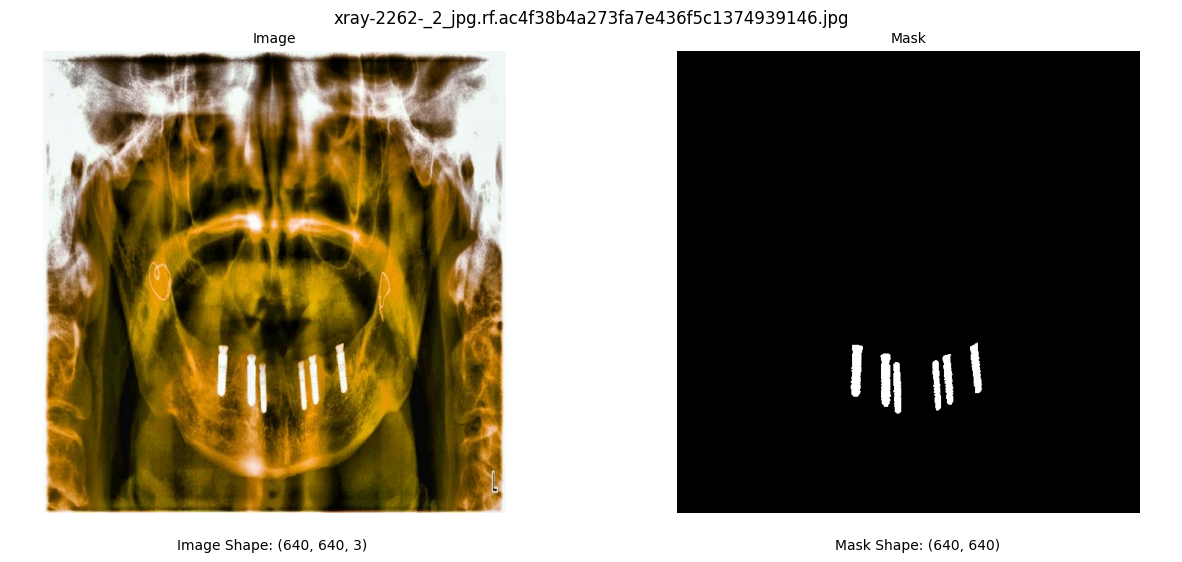

Button(description='clear', style=ButtonStyle())

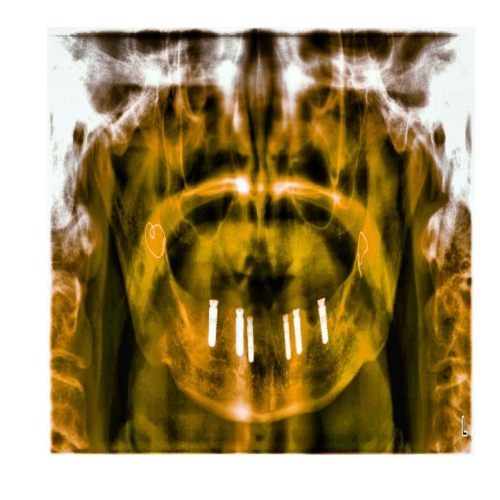

Button(description='save', style=ButtonStyle())

In [6]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(image)


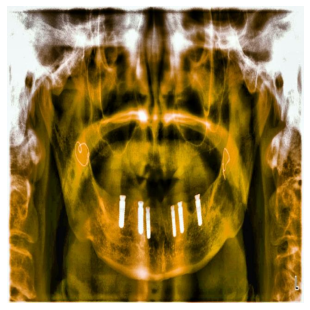

In [7]:
%matplotlib inline
1
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cuda")  # (5, 4)


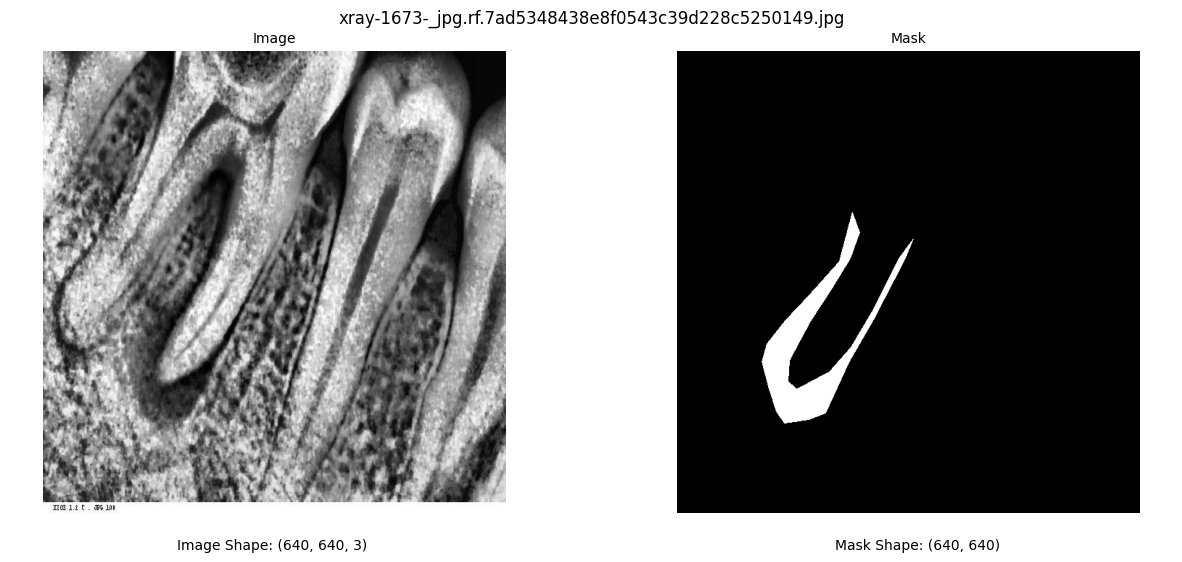

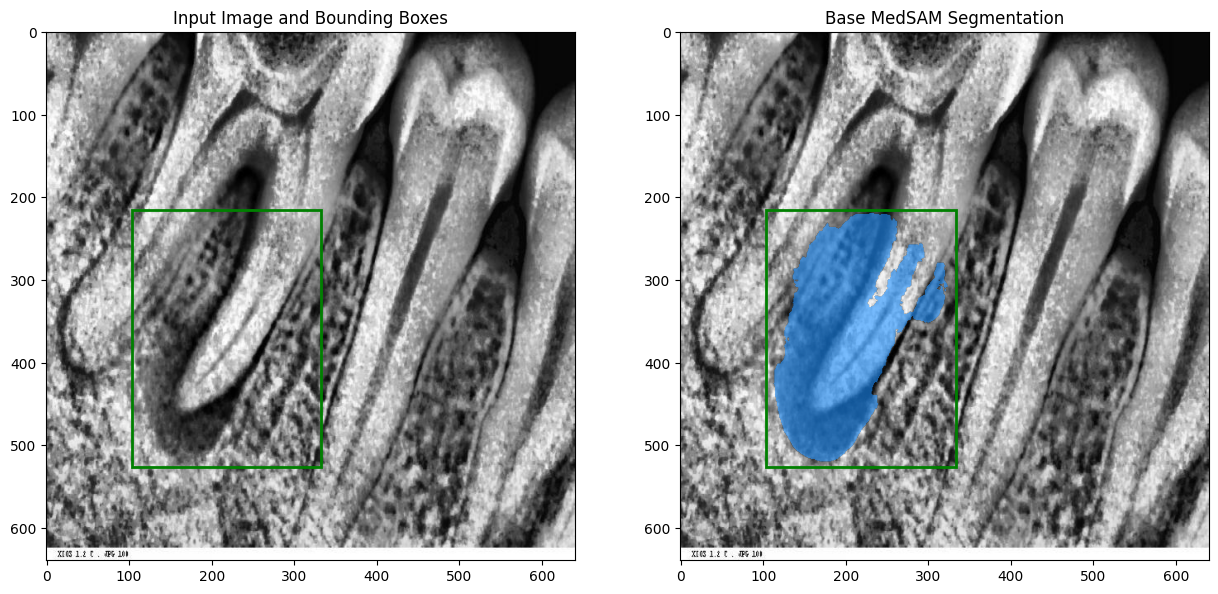

In [8]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(medsam_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

image_idx = 33

# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

### MedSAM Base Model Evaluation

In [9]:
results = evaluator.evaluate_medsam_model()
evaluator.print_results()

Evaluating MedSAM:   0%|          | 0/82 [00:00<?, ?it/s]d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\model_evaluator.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_mask_tensor = torch.tensor(ground_truth_mask_tensor, dtype=torch.float32).unsqueeze(0).to("cuda")
Evaluating MedSAM:  12%|█▏        | 10/82 [00:27<03:14,  2.70s/it]


KeyboardInterrupt: 

# Fine-tuning MedSAM

### Set and verify dataloaders

In [3]:
# Ensure images are returned as preprocessed tensors of the right size
test_dataset.return_as_sam  = True
train_dataset.return_as_sam = True
valid_dataset.return_as_sam = True


test_dataset.resize_mask  = True
train_dataset.resize_mask = True
valid_dataset.resize_mask = True

train_dataset.return_individual_objects = True # Make the other two this as well


# Veryify item sizes
example = train_dataset[0]
for k,v in example.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")

5 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
pixel_values              Shape: torch.Size([3, 1024, 1024])    Dtype: torch.float32
original_sizes            Shape: torch.Size([2])                Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2])                Dtype: torch.int64
input_boxes               Shape: torch.Size([20, 4])            Dtype: torch.float64
ground_truth_mask         Shape: torch.Size([20, 256, 256])     Dtype: torch.float32


d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cpu")  # (5, 4)
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  object_masks = [torch.tenso

In [4]:
# Set up dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False)



# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")


7 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
6 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
pixel_values              Shape: torch.Size([2, 3, 1024, 1024]) Dtype: torch.float32
original_sizes            Shape: torch.Size([2, 2])             Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2, 2])             Dtype: torch.int64
input_boxes               Shape: torch.Size([2, 20, 4])         Dtype: torch.float64
ground_truth_mask         Shape: torch.Size([2, 20, 256, 256])  Dtype: torch.float32


## Fine-Tuning Hugging Face SamProcessor (MedSAM)

In [5]:
# Remove previous models from memory
medsam_model = None
del medsam_model
torch.cuda.empty_cache()

# load the pretrained weights for finetuning
medsam_model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in medsam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [6]:
# Initialize the optimizer and the loss function
optimizer = Adam(medsam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# multi-class segmentation loss (Cross-Entropy + Dice Loss)
def multi_class_loss(predictions, targets):
    ce_loss = F.cross_entropy(predictions, targets)  # Cross-entropy
    dice_loss = DiceLoss(to_onehot_y=True, softmax=True)(predictions, targets)  # Dice loss
    return ce_loss + dice_loss


In [7]:
from statistics import mean
from matplotlib import patches
from torch import nn
from torch.nn.functional import threshold, normalize




#Training loop
num_epochs = 1

device = "cuda"
medsam_model.to(device)

medsam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        print(batch.keys())

       
      
        # Get input image and bounding boxes
        images = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)

        # forward pass
        outputs = medsam_model(pixel_values=batch["pixel_values"].to(device),
                        #input_masks=batch["labels"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

       

        # Get predicted masks and ground truth masks
        predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra singleton dimension from predicted masks (shape: [2, 20, 256, 256])
        ground_truth_masks = batch["ground_truth_mask"].float().to(device).squeeze(1)  # Remove extra singleton dimension from ground truth (shape: [2, 20, 256, 256])

        # Ensure the predicted and ground truth masks have the same shape
        print(predicted_masks.shape)  # Should print [2, 20, 256, 256]
        print(ground_truth_masks.shape)  # Should print [2, 20, 256, 256]

        # Calculate loss
        loss = seg_loss(predicted_masks, ground_truth_masks)


        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

# Save the model's state dictionary to a file
torch.save(medsam_model.state_dict(), "Models/medsam_vit_b_object_masks.pth")
     


  0%|          | 0/850 [00:00<?, ?it/s]

5 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
2 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  0%|          | 1/850 [00:05<1:17:40,  5.49s/it]

4 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
6 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  0%|          | 2/850 [00:11<1:24:43,  5.99s/it]

7 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
10 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  0%|          | 3/850 [00:15<1:11:51,  5.09s/it]

3 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
1 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  0%|          | 4/850 [00:20<1:11:44,  5.09s/it]

16 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
7 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  1%|          | 5/850 [00:25<1:10:48,  5.03s/it]

2 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
1 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  1%|          | 6/850 [00:30<1:08:50,  4.89s/it]

8 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
2 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  1%|          | 7/850 [00:34<1:04:53,  4.62s/it]

4 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
3 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
torch.Size([2, 20, 256, 256])
torch.Size([2, 20, 256, 256])


  1%|          | 8/850 [00:39<1:04:30,  4.60s/it]

10 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
13 20
Bounding Boxes Shape: torch.Size([20, 1, 4])
Ground Truth Mask Shape: torch.Size([20, 256, 256])
dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])


  1%|          | 8/850 [00:40<1:10:56,  5.05s/it]


KeyboardInterrupt: 